In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# mounting drive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [3]:
# extracting files
!unzip '/content/drive/MyDrive/Wider_dataset/WIDER_train.zip'
!unzip '/content/drive/My Drive/Wider_dataset/WIDER_val.zip'
!unzip '/content/drive/My Drive/Wider_dataset/wider_face_split.zip'

Archive:  /content/drive/MyDrive/Wider_dataset/WIDER_train.zip
replace WIDER_train/images/0--Parade/0_Parade_marchingband_1_100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/My Drive/Wider_dataset/WIDER_val.zip
replace WIDER_val/images/0--Parade/0_Parade_marchingband_1_1004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace WIDER_val/images/0--Parade/0_Parade_marchingband_1_104.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace WIDER_val/images/0--Parade/0_Parade_marchingband_1_1045.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace WIDER_val/images/0--Parade/0_Parade_marchingband_1_139.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace WIDER_val/images/0--Parade/0_Parade_marchingband_1_147.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [n]
error:  invalid response [[n]]
replace WIDER_val/images/0--Parade/0_Parade_marchingband_1_147.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/My Drive/Wider_dataset/wider_face_split.zip
replace wider_f

In [39]:
# reading files
import pandas as pd

# specify path of the data
path_train = '/content/wider_face_split/wider_face_train_bbx_gt.txt'
path_val = '/content/wider_face_split/wider_face_val_bbx_gt.txt'

# reading data
train = pd.read_csv(path_train,header=None)
val = pd.read_csv(path_val,header=None)

In [40]:
# pre-processing data
# this function accepts the dataframe and returns modified dataframe
def reformat(df):
  # fetch values of first column
  values = df[0].values
  # creating empty lists
  names=[]
  num_faces=[]
  bbox=[]
  # fetch values into corresponding lists
  for i in range(len(values)):
      
      # if an image
      if ".jpg" in values[i]:
        
        # no. of faces
        num=int(values[i+1])
        
        # append image name to list
        names.append(values[i])
        
        # append no. of faces to list
        num_faces.append(num)
        
        # create bbox list
        box=[]
        for j in range(i+2,i+2+num):
          box.append(values[j])
        
        # append bbox list to list
        bbox.append(box)
  
  #return pd.DataFrame({'name':names,'num_faces':num_faces,'bbox':bbox})
  return pd.DataFrame({'name':names,'bbox':bbox})

In [41]:
# pre-processing the data 
train = reformat(train)
val = reformat(val)

In [42]:
# adding full path
train['name'] = train['name'].apply(lambda x: 'WIDER_train/images/'+x )
val['name']   = val['name'].apply(lambda x: 'WIDER_val/images/'+x )

In [43]:
train

,name,bbox
0,WIDER_train/images/0--Parade/0_Parade_marching...,[449 330 122 149 0 0 0 0 0 0 ]
1,WIDER_train/images/0--Parade/0_Parade_Parade_0...,[361 98 263 339 0 0 0 0 0 0 ]
2,WIDER_train/images/0--Parade/0_Parade_marching...,"[78 221 7 8 2 0 0 0 0 0 , 78 238 14 17 2 0 0 0..."
3,WIDER_train/images/0--Parade/0_Parade_marching...,"[69 359 50 36 1 0 0 0 0 1 , 227 382 56 43 1 0 ..."
4,WIDER_train/images/0--Parade/0_Parade_marching...,"[27 226 33 36 1 0 0 0 2 0 , 63 95 16 19 2 0 0 ..."
...,...,...
12875,WIDER_train/images/9--Press_Conference/9_Press...,[462 140 264 362 0 0 0 0 0 0 ]
12876,WIDER_train/images/9--Press_Conference/9_Press...,[362 108 214 277 0 0 0 0 0 0 ]
12877,WIDER_train/images/9--Press_Conference/9_Press...,[495 222 165 222 0 0 0 0 0 0 ]
12878,WIDER_train/images/9--Press_Conference/9_Press...,[244 46 510 614 0 0 0 0 0 0 ]


In [44]:
train.shape

(12880, 2)

In [45]:
val.shape

(3226, 2)

In [46]:
#from IPython.display import Image, display
#display(Image(train.name[0]))

In [47]:
# converting bbox to floating point
import numpy as np
train['bbox'] = train['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )
val['bbox']   = val['bbox'].apply(lambda row:[ np.float_(annos.split()) for annos in row] )

In [48]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms

In [49]:
def annotate_image(annotations,j, resize=True):
  file_name = annotations.name[j]
  img = cv2.cvtColor(cv2.imread(file_name), cv2.COLOR_BGR2RGB)
  for i in annotations.bbox[j]:    
    cv2.rectangle(img, (int(i[0]), int(i[1])), (int(i[0])+int(i[2]), int(i[1])+int(i[3])), (0, 255, 0), 2)

  if not resize:
    return img

  return cv2.resize(img, (384, 384), interpolation = cv2.INTER_AREA)

(-0.5, 1023.5, 680.5, -0.5)

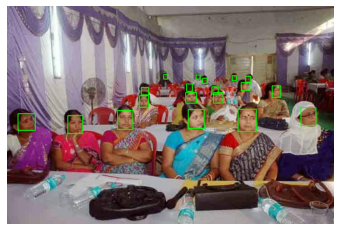

In [50]:
j=0
while j<880:
  img_df = train
  img = annotate_image(img_df,j, resize=False)
  train.name[j]=img
  j+=1
plt.imshow(img)
plt.axis('off')

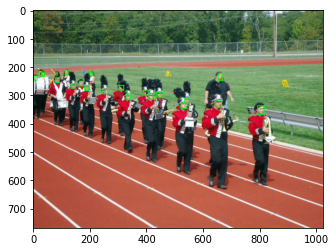

In [26]:
plt.imshow(train.name[2])

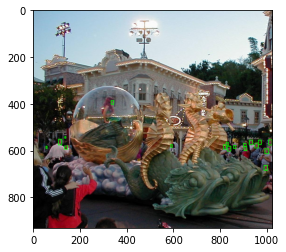

In [25]:
plt.imshow(train.name[5])

In [55]:
sample_images = train.name[:880]
sample_images

0      [[[237, 251, 255], [237, 251, 255], [237, 251,...
1      [[[78, 85, 101], [76, 83, 99], [73, 82, 97], [...
2      [[[85, 104, 40], [89, 108, 44], [94, 115, 48],...
3      [[[79, 86, 94], [79, 86, 94], [79, 86, 94], [8...
4      [[[124, 114, 139], [127, 115, 139], [130, 117,...
                             ...                        
875    [[[104, 121, 129], [87, 104, 112], [63, 80, 88...
876    [[[255, 255, 255], [255, 255, 255], [255, 255,...
877    [[[31, 47, 47], [30, 46, 46], [29, 45, 45], [2...
878    [[[19, 19, 19], [19, 19, 19], [19, 19, 19], [2...
879    [[[99, 83, 122], [126, 110, 149], [153, 137, 1...
Name: name, Length: 880, dtype: object

In [57]:
import torch
sample_images.shape

(880,)

In [ ]:
from torchvision.transforms.transforms import Resize
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#train transform e to tensor o dentro trainloader
trainloader = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(val, batch_size=4,
                                         shuffle=False, num_workers=2)